### Importing all the required libraries

In [285]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
from sklearn import metrics
from numpy import mean
from numpy import std
import plotly.graph_objects as go

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV


### Loading Dataset

In [286]:
data = pd.read_csv('data_csv.csv')

In [287]:
data.head()


,date,zip,state,lat,long,race,Age,Gender,Pollen_Tree,Pollen_weed,Pollen_Grass,Exacb
0,2/10/2018,23409,VA,37.859953,-75.629950,White,63,Female,5,0,2,Yes
1,8/27/2015,99348,WA,46.408852,-118.448760,Black,50,Male,1,0,4,No
2,7/28/2018,68902,NE,40.589594,-98.397248,Other,22,Female,1,0,2,No
3,1/29/2012,55746,MN,47.413817,-92.942280,Other,34,Male,1,0,5,No
4,5/26/2012,81073,CO,37.409787,-102.617260,Black,44,Female,1,0,2,No


In [288]:
data.shape

(1193, 12)

In [289]:
data.dtypes

date             object
zip               int64
state            object
lat             float64
long            float64
race             object
Age               int64
Gender           object
Pollen_Tree       int64
Pollen_weed       int64
Pollen_Grass      int64
Exacb            object
dtype: object

In [290]:
#changing Zip from int to object as it doesnot behave as ordinal variable 
data['zip']= data['zip'].astype(str)

In [291]:
data.describe()

,lat,long,Age,Pollen_Tree,Pollen_weed,Pollen_Grass
count,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000
mean,38.386727,-91.215451,40.173512,2.481978,2.148365,2.274937
std,5.285788,15.124762,13.529085,1.738785,1.529558,1.560261
min,18.003125,-169.559580,18.000000,0.000000,0.000000,0.000000
25%,35.101727,-97.209180,28.000000,1.000000,1.000000,1.000000
50%,39.036361,-88.161240,40.000000,3.000000,2.000000,2.000000
75%,41.689600,-80.467765,52.000000,4.000000,3.000000,3.000000
max,63.882081,-66.011940,65.000000,5.000000,5.000000,5.000000


In [292]:
data.describe(include='object')

,date,zip,state,race,Gender,Exacb
count,1193,1193,1193,1193,1193,1193
unique,965,1176,52,5,2,2
top,12/21/2016,36087,CA,Unknown,Female,No
freq,4,2,81,258,597,904


In [293]:
#Null value in each column
data.isnull().sum()

date            0
zip             0
state           0
lat             0
long            0
race            0
Age             0
Gender          0
Pollen_Tree     0
Pollen_weed     0
Pollen_Grass    0
Exacb           0
dtype: int64

In [294]:
#If any missing value found 
#creating a transform function to fill missing value by either mean or mode 
f = lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]
data = data.fillna(data.groupby('race').transform(f))


### Exploratory Data Analysis

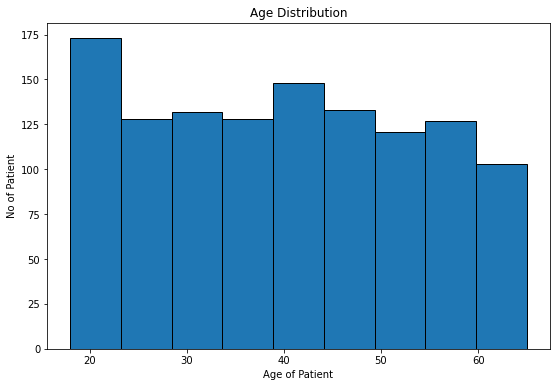

In [295]:
plt.figure(figsize=(9,6))
plt.hist(data['Age'], bins=9, edgecolor='black')
plt.xlabel('Age of Patient')
plt.ylabel('No of Patient')
plt.title('Age Distribution')
plt.show()

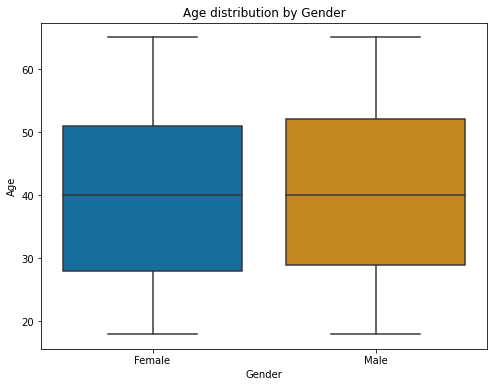

In [296]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data, x='Gender',y='Age',palette='colorblind')
plt.title("Age distribution by Gender")
plt.ylabel("Age")
plt.xlabel("Gender")
plt.show()

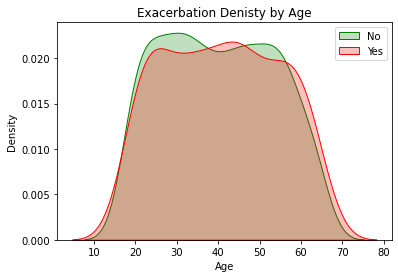

In [297]:
age_sur = sns.kdeplot(data["Age"][(data["Exacb"] == 'No')], color="Green", shade = True)
age_sur = sns.kdeplot(data["Age"][(data["Exacb"] == 'Yes')], ax = age_sur, color="Red", shade= True)
age_sur.set_xlabel("Age")
age_sur.set_ylabel("Density")
age_sur.set_title("Exacerbation Denisty by Age")
age_sur = age_sur.legend(["No","Yes"])

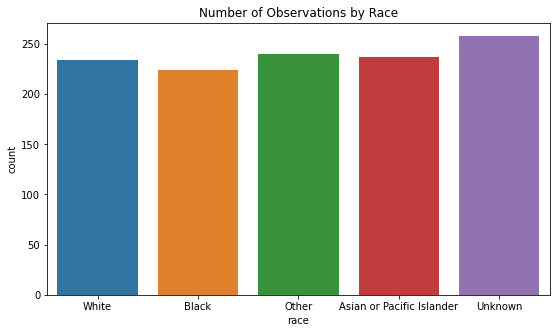

In [298]:
plt.figure(figsize=(9,5))
sns.countplot(data = data, x= 'race')
plt.title("Number of Observations by Race")
plt.show()

In [299]:
d = dict(Yes = 'red', No = 'green')
#fig = px.scatter_geo(data,lat='lat',lon='long' , text = data['Age'], marker_color = data['Exacb'])

fig = go.Figure(data=go.Scattergeo(
        lon = data['long'],
        lat = data['lat'],
        text = data['Exacb'],
        mode = 'markers',
        marker_color = [d[s] for s in data['Exacb']],
        ))
           
fig.update_layout(
        title = '''Patients check Ins: 
        Experienced exacerbation: Red
        Didn't experience difficulties: Green''',
        geo_scope='usa',
    )
fig.show()

### Correlation Matrix

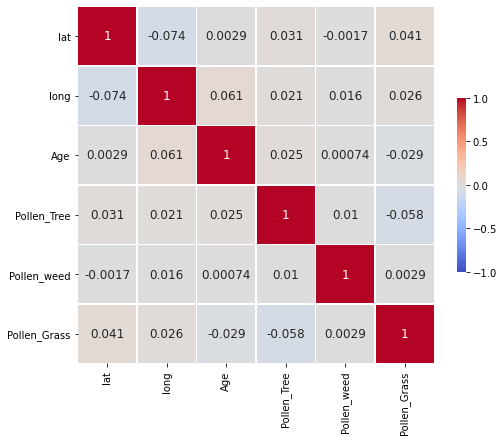

In [300]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(8, 8)) 
heatmap = sns.heatmap(corr_matrix, 
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

No Multicolinearity observed

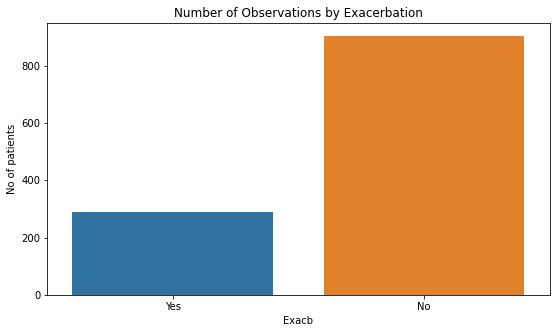

In [301]:
plt.figure(figsize=(9,5))
sns.countplot(data = data, x= 'Exacb')
plt.title("Number of Observations by Exacerbation")
plt.ylabel('No of patients')
plt.show()

In [302]:
data.describe(include='object')

,date,zip,state,race,Gender,Exacb
count,1193,1193,1193,1193,1193,1193
unique,965,1176,52,5,2,2
top,12/21/2016,36087,CA,Unknown,Female,No
freq,4,2,81,258,597,904


### Encoding

In [303]:
#making a copy of data before encoding
edata = data.copy()

In [304]:
encode=LabelEncoder()
catcol = ['zip','state']

In [305]:
edata[catcol] = edata[catcol].apply(encode.fit_transform)

In [306]:
edata = pd.get_dummies(edata, prefix= ['Gender'], columns = ['Gender'])
edata = pd.get_dummies(edata, prefix= ['race'], columns = ['race'])

In [307]:
edata.head(5)

,date,zip,state,lat,long,Age,Pollen_Tree,Pollen_weed,Pollen_Grass,Exacb,Gender_Female,Gender_Male,race_Asian or Pacific Islander,race_Black,race_Other,race_Unknown,race_White
0,2/10/2018,192,46,37.859953,-75.629950,63,5,0,2,Yes,1,0,0,0,0,0,1
1,8/27/2015,1170,48,46.408852,-118.448760,50,1,0,4,No,0,1,0,1,0,0,0
2,7/28/2018,819,29,40.589594,-98.397248,22,1,0,2,No,1,0,0,0,1,0,0
3,1/29/2012,643,23,47.413817,-92.942280,34,1,0,5,No,0,1,0,0,1,0,0
4,5/26/2012,970,5,37.409787,-102.617260,44,1,0,2,No,1,0,0,1,0,0,0


In [308]:
edata.describe(include='object')

,date,Exacb
count,1193,1193
unique,965,2
top,12/21/2016,No
freq,4,904


In [309]:
#removing date variable, 
#week/month/year can be extracted as feature

edata.drop('date', axis=1, inplace=True)

In [310]:
edata.drop('zip', axis=1, inplace=True)

In [311]:
#needs scaling
scale = StandardScaler()
edata['lat'] = scale.fit_transform(np.array(edata['lat']).reshape(-1,1))
edata['long'] = scale.fit_transform(np.array(edata['long']).reshape(-1,1))

In [312]:
edata.head()

,state,lat,long,Age,Pollen_Tree,Pollen_weed,Pollen_Grass,Exacb,Gender_Female,Gender_Male,race_Asian or Pacific Islander,race_Black,race_Other,race_Unknown,race_White
0,46,-0.099700,1.030895,63,5,0,2,Yes,1,0,0,0,0,0,1
1,48,1.518315,-1.801333,50,1,0,4,No,0,1,0,1,0,0,0
2,29,0.416928,-0.475036,22,1,0,2,No,1,0,0,0,1,0,0
3,23,1.708520,-0.114220,34,1,0,5,No,0,1,0,0,1,0,0
4,5,-0.184901,-0.754167,44,1,0,2,No,1,0,0,1,0,0,0


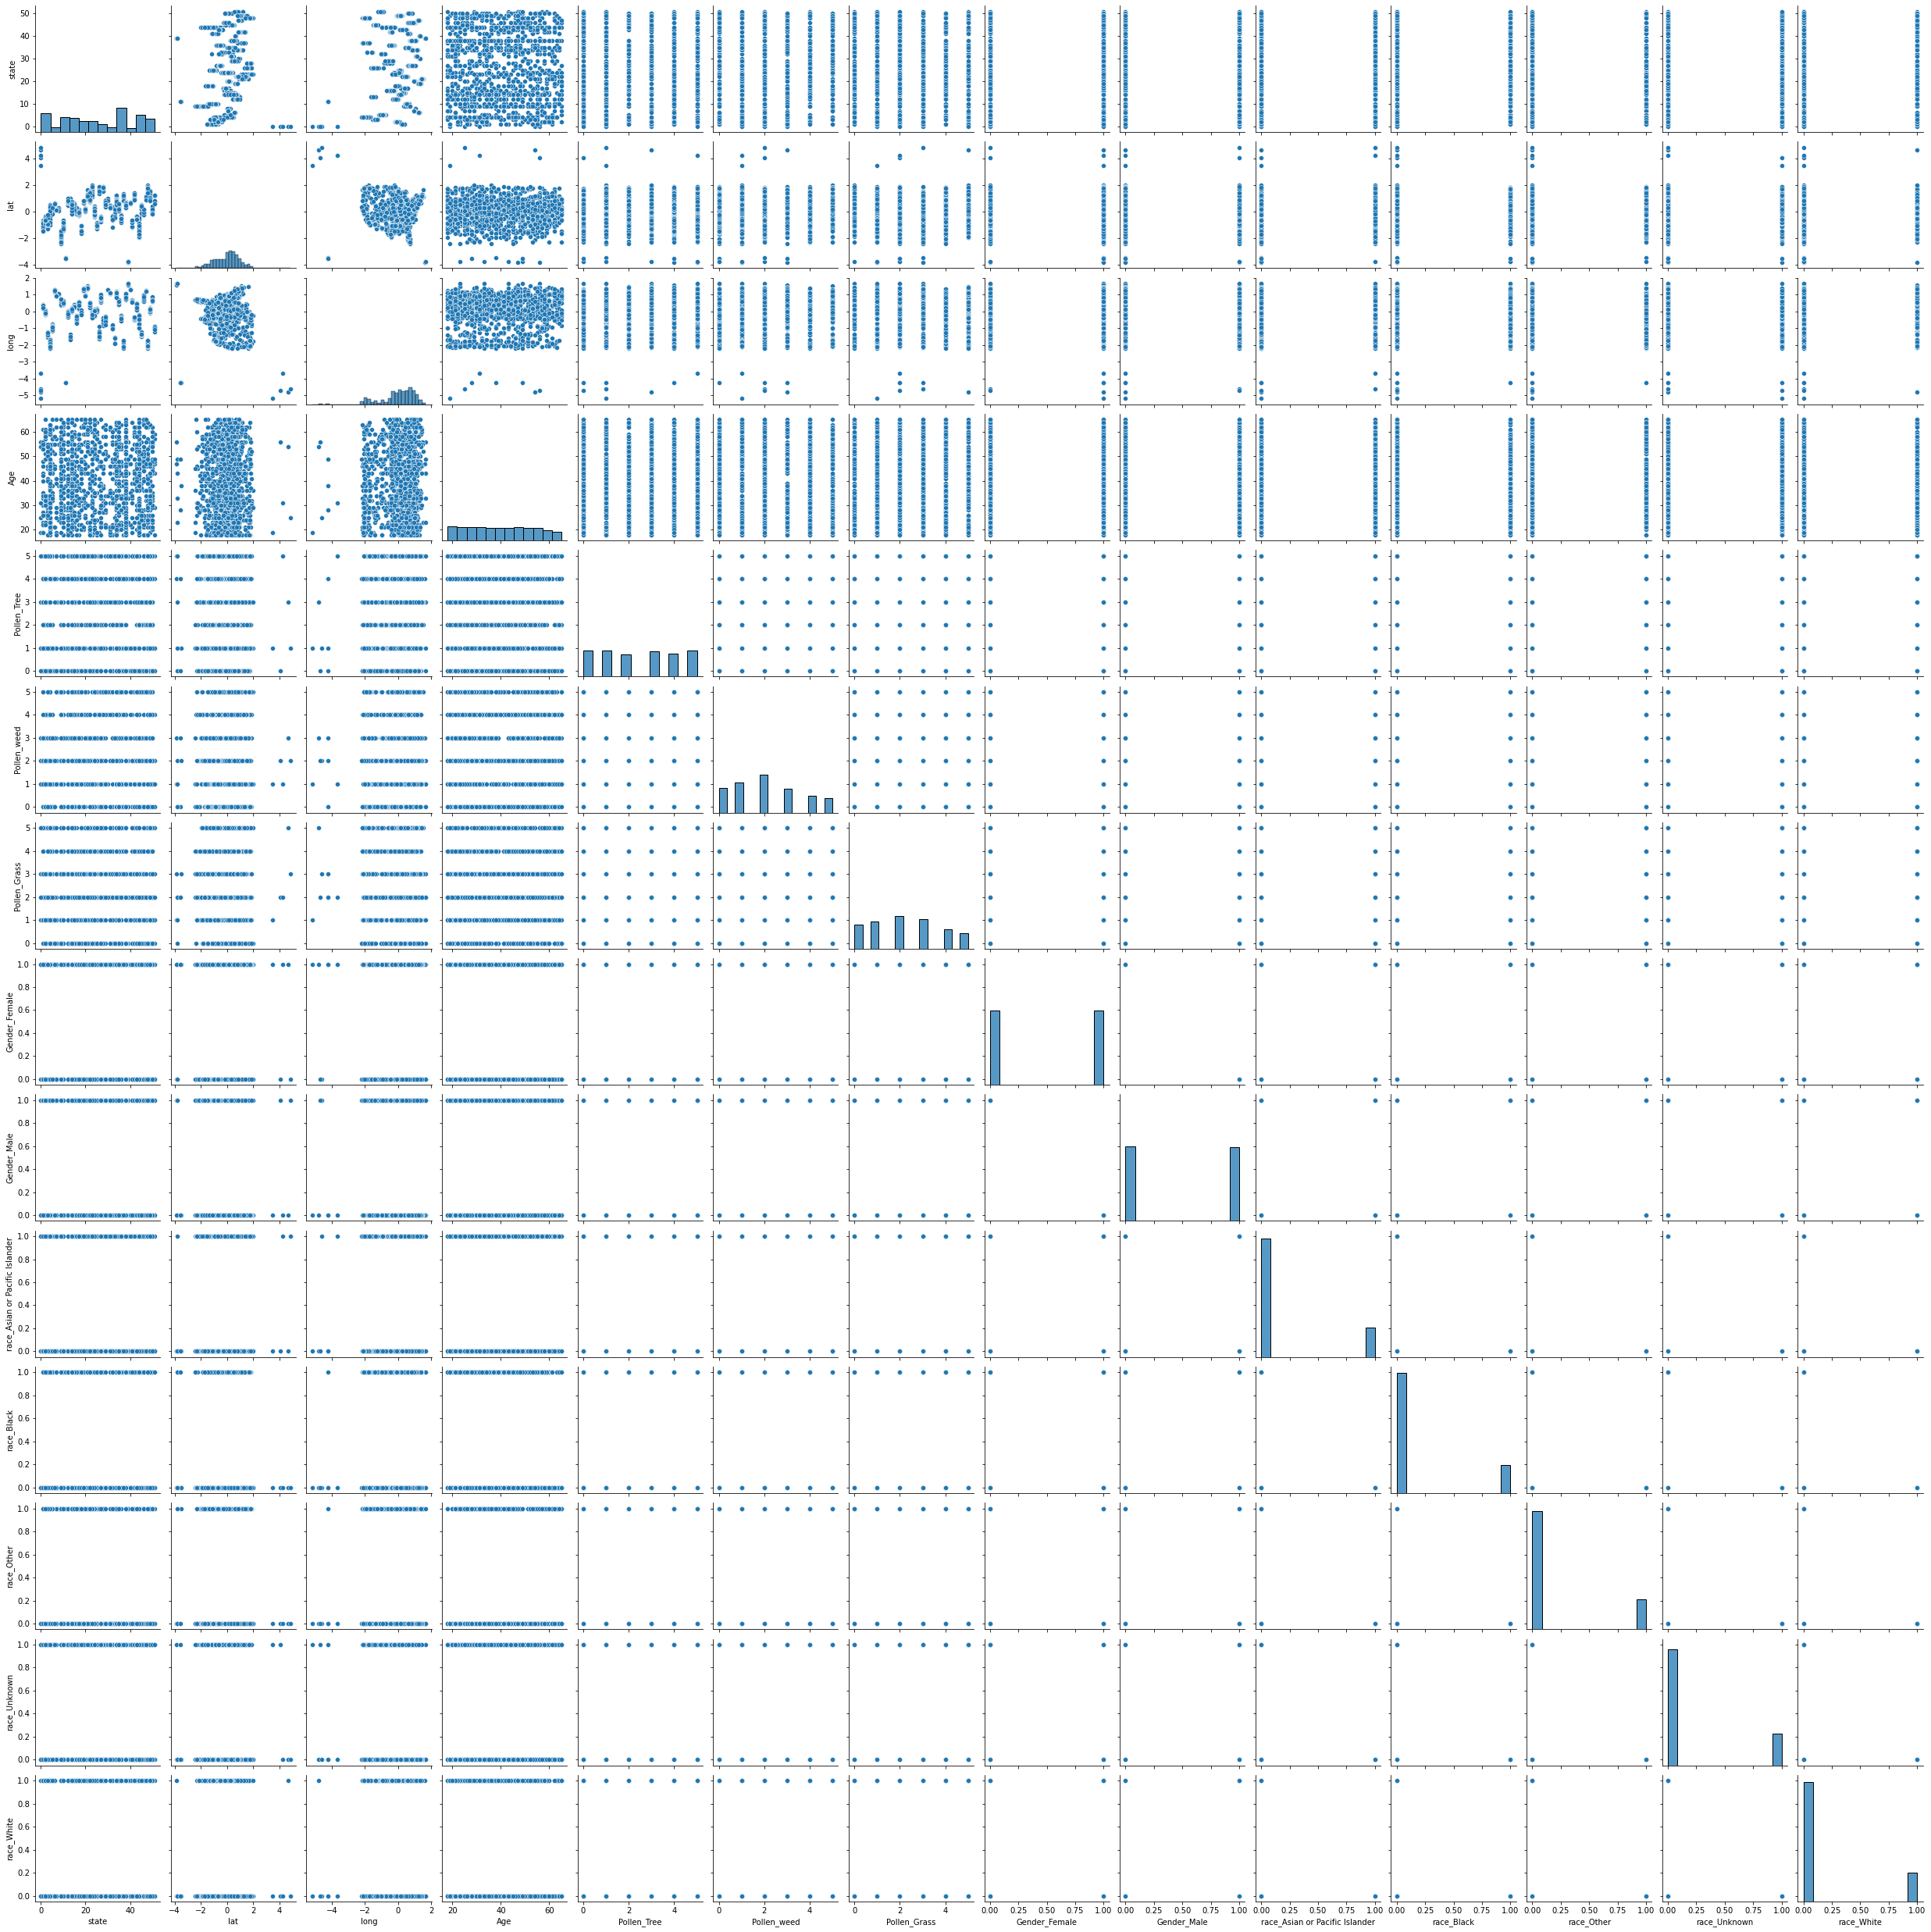

In [380]:
#To check for any patterns or correlations in the encoded data variables
sns.pairplot(edata)

### Modeling

In [314]:
X = edata.drop(columns='Exacb')
y = edata.Exacb

### Test/Train sample split

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 21)

### Model 1: Decision Tree

In [316]:
model1 = DecisionTreeClassifier(max_leaf_nodes= 6, random_state = 21)
model1.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=6, random_state=21)

In [317]:
y_pred1= model1.predict(X_test)
model1_accu = accuracy_score(y_test, y_pred1)
print("Accuracy of Decision Tree is    : {:.2f}"
          .format(model1_accu))

Accuracy of Decision Tree is    : 0.83


<Figure size 360x360 with 0 Axes>

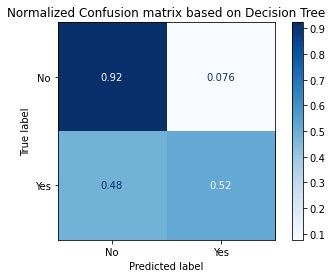

In [318]:
plt.figure(figsize=(5,5))
plot_confusion_matrix(model1, X_test, y_test, cmap=plt.cm.Blues, normalize='true', display_labels= ["No", 'Yes'])  
plt.title("Normalized Confusion matrix based on Decision Tree")
plt.show()

In [319]:
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

[[254  21]
 [ 40  43]]
              precision    recall  f1-score   support

          No       0.86      0.92      0.89       275
         Yes       0.67      0.52      0.59        83

    accuracy                           0.83       358
   macro avg       0.77      0.72      0.74       358
weighted avg       0.82      0.83      0.82       358



### Model 2: KNN

In [320]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [321]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [322]:
y_pred4 = classifier.predict(X_test)

In [323]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

[[258  17]
 [ 56  27]]
              precision    recall  f1-score   support

          No       0.82      0.94      0.88       275
         Yes       0.61      0.33      0.43        83

    accuracy                           0.80       358
   macro avg       0.72      0.63      0.65       358
weighted avg       0.77      0.80      0.77       358



In [324]:
error = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

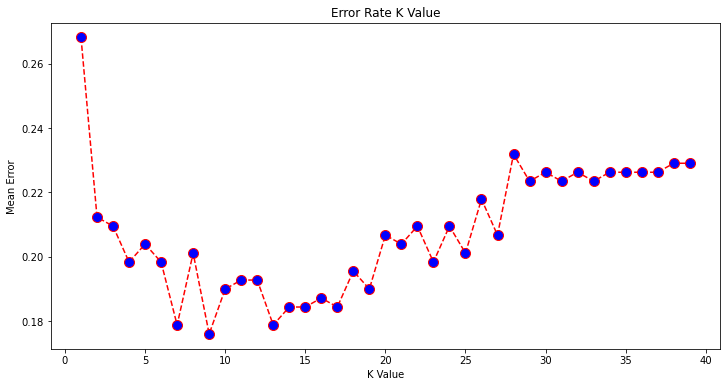

In [325]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Fitting new model with k as 10 as the k value around 10 has the lowest error in the above chart

In [326]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [327]:
y_pred5 = classifier.predict(X_test)

In [328]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred5))
print(classification_report(y_test, y_pred5))

[[273   2]
 [ 66  17]]
              precision    recall  f1-score   support

          No       0.81      0.99      0.89       275
         Yes       0.89      0.20      0.33        83

    accuracy                           0.81       358
   macro avg       0.85      0.60      0.61       358
weighted avg       0.83      0.81      0.76       358



### Model 3: Support Vector Machine

In [329]:
clf = svm.SVC(kernel='linear')
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [330]:
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.8575418994413407


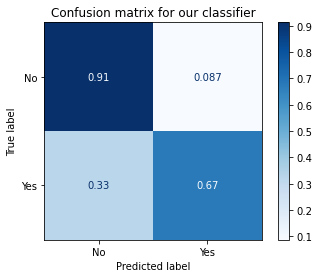

In [331]:
matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

In [332]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[251  24]
 [ 27  56]]
              precision    recall  f1-score   support

          No       0.90      0.91      0.91       275
         Yes       0.70      0.67      0.69        83

    accuracy                           0.86       358
   macro avg       0.80      0.79      0.80       358
weighted avg       0.86      0.86      0.86       358



### Model 4: Random Forest 

In [333]:
rfc = RandomForestClassifier(random_state=0)

In [334]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [335]:
y_pred7 = rfc.predict(X_test)

In [336]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred7)))

Model accuracy score with 10 decision-trees : 0.8631


In [337]:
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set

rfc_100.fit(X_train, y_train)

# Predict on the test set results

y_pred_100 = rfc_100.predict(X_test)

# Check accuracy score 

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.8631


In [338]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred7))

              precision    recall  f1-score   support

          No       0.88      0.95      0.91       275
         Yes       0.77      0.59      0.67        83

    accuracy                           0.86       358
   macro avg       0.82      0.77      0.79       358
weighted avg       0.86      0.86      0.86       358



In [339]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [340]:
from sklearn.model_selection import GridSearchCV
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [341]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

Fitting new Random forest model with best parameters determined to check for an increase in accuracy

In [342]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='entropy')

In [343]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=42)

In [344]:
preds = rfc1.predict(X_test)

In [345]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred7)))

Model accuracy score with 10 decision-trees : 0.8631


###  Synthetic Minority Oversampling Technique

Generating synthetic data for the minority class to balance target class distribution 

In [346]:
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({'No': 904, 'Yes': 289})
Resample dataset shape Counter({'Yes': 904, 'No': 904})


In [347]:
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state= 21)
    

### Model 1: KNN (With balanced target class)

In [348]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [349]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [350]:
y_pred4 = classifier.predict(X_test)

In [351]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

[[243  23]
 [ 77 200]]
              precision    recall  f1-score   support

          No       0.76      0.91      0.83       266
         Yes       0.90      0.72      0.80       277

    accuracy                           0.82       543
   macro avg       0.83      0.82      0.81       543
weighted avg       0.83      0.82      0.81       543



In [352]:
error = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

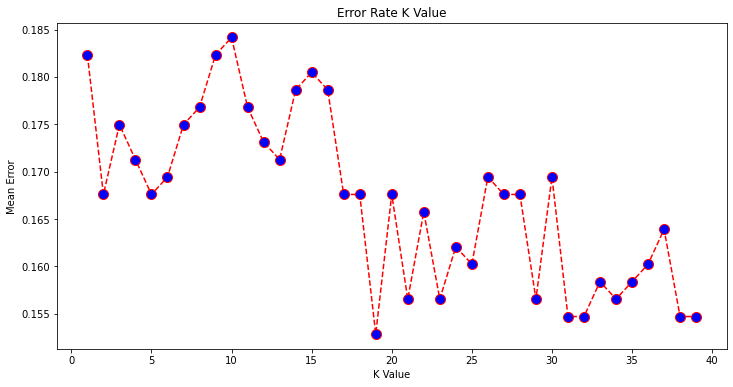

In [353]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Fitting new model with k as 31 as the k value around 30 has the lowest error in the above chart

In [354]:
classifier = KNeighborsClassifier(n_neighbors=31)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=31)

In [355]:
y_pred4 = classifier.predict(X_test)

In [356]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

[[247  19]
 [ 65 212]]
              precision    recall  f1-score   support

          No       0.79      0.93      0.85       266
         Yes       0.92      0.77      0.83       277

    accuracy                           0.85       543
   macro avg       0.85      0.85      0.84       543
weighted avg       0.86      0.85      0.84       543



In [357]:
# Import the AdaBoost classifier

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)

# Train Adaboost Classifer
classifier1 = abc.fit(X_train, y_train)


#Predict the response for test dataset
adaknn = classifier1.predict(X_test)

In [358]:
# calculate and print model accuracy
print("AdaBoost Classifier Model Accuracy:", accuracy_score(y_test, adaknn))

AdaBoost Classifier Model Accuracy: 0.856353591160221


[0.08992879 0.09767126 0.09937923 0.09567459 0.27532163 0.12222492
 0.11299712 0.0115878  0.01328271 0.01526607 0.0175127  0.01795202
 0.01649231 0.01470885]


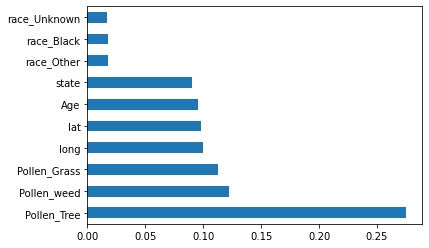

In [359]:
model_feature1 = ExtraTreesClassifier()
model_feature1.fit(X, y)
print(model_feature1.feature_importances_)
feat_importances = pd.Series(model_feature1.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Model 2: Support Vector Machine (With balanced target class)

In [360]:
clf = svm.SVC(kernel='linear')
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [361]:
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.8895027624309392


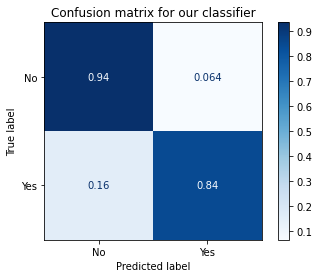

In [362]:
matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

In [363]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[249  17]
 [ 43 234]]
              precision    recall  f1-score   support

          No       0.85      0.94      0.89       266
         Yes       0.93      0.84      0.89       277

    accuracy                           0.89       543
   macro avg       0.89      0.89      0.89       543
weighted avg       0.89      0.89      0.89       543



### Model 3: Random Forest (With balanced target class)

In [364]:
rfc = RandomForestClassifier(random_state=0)

In [365]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [366]:
y_pred7 = rfc.predict(X_test)

In [367]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred7)))

Model accuracy score with 10 decision-trees : 0.8785


[0.0904652  0.0985558  0.09856791 0.09494468 0.27541738 0.1228015
 0.11098109 0.012766   0.0133899  0.01484305 0.01642976 0.01762011
 0.01755663 0.01566098]


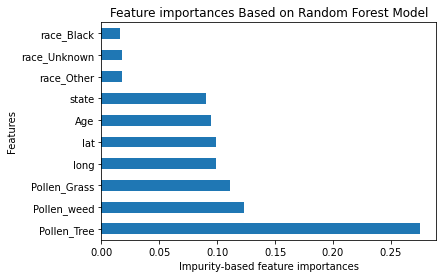

In [368]:

model_feature2 = ExtraTreesClassifier()
model_feature2.fit(X, y)
print(model_feature2.feature_importances_)
feat_importances = pd.Series(model_feature2.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('Feature Importance')
plt.title("Feature importances Based on Random Forest Model")
plt.xlabel('Impurity-based feature importances')
plt.show()

In [369]:
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set

rfc_100.fit(X_train, y_train)

# Predict on the test set results

y_pred_100 = rfc_100.predict(X_test)

# Check accuracy score 

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.8785


In [370]:
print(classification_report(y_test, y_pred7))

              precision    recall  f1-score   support

          No       0.86      0.90      0.88       266
         Yes       0.90      0.86      0.88       277

    accuracy                           0.88       543
   macro avg       0.88      0.88      0.88       543
weighted avg       0.88      0.88      0.88       543



In [371]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [372]:

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [373]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [381]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='entropy')

In [382]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=200,
                       random_state=42)

In [383]:
preds = rfc1.predict(X_test)

In [384]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred7)))

Model accuracy score with 10 decision-trees : 0.8785


In [385]:

print(classification_report(y_test, y_pred7))

              precision    recall  f1-score   support

          No       0.86      0.90      0.88       266
         Yes       0.90      0.86      0.88       277

    accuracy                           0.88       543
   macro avg       0.88      0.88      0.88       543
weighted avg       0.88      0.88      0.88       543

